# PSCC'24 - Experiments - Denmark Dataset

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import torch
from model_lib import *
from dataset_lib import *
from utils_lib import *
import torch_two_sample as tts
import itertools
from tqdm.notebook import tqdm

### Load Data

In [2]:
dset_params_dict = {'year_start': 2019, "year_end": 2020, "temporal_aggregate_level": 1}
data, data_mean, data_std = get_dataset("denmark", dset_params_dict)
N_total, NUM_DIMS = data.shape[0], data.shape[1]
print('Dataset: %s, N_total: %d, num_dims: %d' % ("Denmark", N_total, NUM_DIMS))

Dataset: Denmark, N_total: 8784, num_dims: 8


### Split Data

In [3]:
train_data, val_data = split_dataset(data, test_set_ratio=0.2)
train_data, val_data = torch.from_numpy(train_data).float(), torch.from_numpy(val_data).float()
N = train_data.shape[0]

### Dataloader for Gradient Training

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data): self.data = data
    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx], idx

dataset = Dataset(train_data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=False, drop_last=True)

## Initial Train Configs

In [5]:
train_kwargs = {'x' : train_data, 
                'x_val' : val_data,
                'modified_em' : True,
                'dataloader' : dataloader}

## Automated Testing

In [11]:
config_dict = {'learn_weights': [False,True],
                'modified_em': [True],
                }

In [12]:
kde_logs_df = pd.DataFrame({key: [] for key in config_dict.keys()}).astype({key: type(value[0]) for key, value in config_dict.items()})
kde_logs_df['logs'], kde_logs_df['model'], kde_logs_df['gmm'] = [], [], []
kde_logs_df['gmm'] = kde_logs_df['gmm'].astype(bool)

In [13]:
for learn_weights, modified_em in itertools.product(config_dict['learn_weights'],config_dict['modified_em']):
    train_kwargs['modified_em'] = modified_em

    model = KernelDensityEstimator(mu=train_data, learn_weights=learn_weights)
    logs = model.train(**train_kwargs)
    kde_logs_df = pd.concat([kde_logs_df, pd.DataFrame({'learn_weights':learn_weights, 'modified_em': train_kwargs['modified_em'], 'logs':[logs], 'gmm':False, 'model':model})], ignore_index=True)
    print('learn_weights: %s, modified_em: %s' % (learn_weights, train_kwargs['modified_em']))

kde_logs_df = pd.concat([kde_logs_df, pd.DataFrame({'log_likelihood_loo':kde_logs_df['logs'].apply(lambda x: x['log_likelihood_loo'][-1]),
                                                    'log_likelihood_val':kde_logs_df['logs'].apply(lambda x: x['log_likelihood_val'][-1]),
                                                    'num_kernels':kde_logs_df['logs'].apply(lambda x: x['num_kernels'][-1]),
                                                    'num_params':kde_logs_df['logs'].apply(lambda x: x['num_params'][-1]),
                                                    'time':kde_logs_df['logs'].apply(lambda x: x['time'])})], axis=1)


learn_weights: False, modified_em: True
learn_weights: True, modified_em: True


## Compare with GMMs

In [14]:
num_kde_params = kde_logs_df['num_params'].unique()
num_gmm_kernels = (num_kde_params//(NUM_DIMS + NUM_DIMS * (NUM_DIMS + 1) / 2 + 1)).astype(int)
num_gmm_kernels = np.unique(np.concatenate([num_gmm_kernels]))

In [15]:
gmm_logs_df = pd.DataFrame({key: [] for key in config_dict.keys()}).astype({key: type(value[0]) for key, value in config_dict.items()})
gmm_logs_df['logs'], gmm_logs_df['model'], gmm_logs_df['gmm'] = [], [], []
gmm_logs_df['gmm'] = gmm_logs_df['gmm'].astype(bool)

In [16]:
for num_kernels in num_gmm_kernels:
    model = GaussianMixtureModelBenchmark(num_kernels=num_kernels, n_features=NUM_DIMS)
    logs = model.train(x=train_data, x_val=val_data)
    gmm_logs_df = pd.concat([gmm_logs_df, pd.DataFrame({'learn_weights':True, 'logs':[logs], 'gmm':True, 'model':model})], ignore_index=True)
    print('num_kernels: %d' % num_kernels)

gmm_logs_df = pd.concat([gmm_logs_df, pd.DataFrame({'log_likelihood_val':gmm_logs_df['logs'].apply(lambda x: x['log_likelihood_val'].numpy()),
                                                    'num_kernels':gmm_logs_df['logs'].apply(lambda x: x['num_kernels']),
                                                    'num_params':gmm_logs_df['logs'].apply(lambda x: x['num_params']),
                                                    'time':gmm_logs_df['logs'].apply(lambda x: x['time'])})], axis=1)

num_kernels: 156
num_kernels: 312


In [17]:
exp_logs_df = pd.concat([kde_logs_df, gmm_logs_df], ignore_index=True)

## Testers

In [18]:
MC_runs = 2000
n_perms = 1

test_portion = 0.5

test_data = val_data
num_samples = train_data.shape[0]
n_1 = int(test_data.shape[0]*test_portion)
n_2 = n_1

basescores_df = pd.DataFrame(columns=['mmd_test', 'energy_test'])

mmd_tester = tts.statistics_diff.MMDStatistic(n_1=n_1, n_2=n_2)
energy_tester = tts.statistics_diff.EnergyStatistic(n_1=n_1, n_2=n_2)

testers = [mmd_tester, energy_tester]
base_scores = np.zeros((len(testers), MC_runs))

pbar_mc = tqdm(total=MC_runs, desc='MC runs')

train_samples = train_data
for j in range(MC_runs):
    for k, tester in enumerate(testers):
        score = tester(test_data[torch.randperm(test_data.shape[0])[:n_1]], train_samples[torch.randperm(train_samples.shape[0])[:n_2]], ret_matrix=False)
        base_scores[k,j] = score
    pbar_mc.update(1)
basescores_df.loc[0] = [base_scores[k, :] for k in range(len(testers))]
base_df = pd.concat({"scores": basescores_df}, axis=1)

MC runs:   0%|          | 0/2000 [00:00<?, ?it/s]

In [19]:
scores_df = pd.DataFrame(columns=['mmd_test', 'energy_test'])

pbar_models = tqdm(total=exp_logs_df.shape[0], desc='Models')
pbar_mc = tqdm(total=MC_runs, desc='MC runs')

for i, model in enumerate(exp_logs_df['model']):
    mmd_tester = tts.statistics_diff.MMDStatistic(n_1=n_1, n_2=n_2)
    energy_tester = tts.statistics_diff.EnergyStatistic(n_1=n_1, n_2=n_2)

    testers = [mmd_tester, energy_tester]
    scores = np.zeros((len(testers), MC_runs))

    model_samples = model.sampling(num_samples)
    
    pbar_mc.reset()
    for j in range(MC_runs):
        for k, tester in enumerate(testers):
            score = tester(test_data[torch.randperm(test_data.shape[0])[:n_1]], model_samples[torch.randperm(model_samples.shape[0])[:n_2]], ret_matrix=False)
            scores[k,j] = score
        pbar_mc.update(1)
    pbar_models.update(1)
    scores_df.loc[i] = [scores[k, :] for k in range(len(testers))]
exp_df = pd.concat({"scores": scores_df}, axis=1)

Models:   0%|          | 0/4 [00:00<?, ?it/s]

MC runs:   0%|          | 0/2000 [00:00<?, ?it/s]

In [20]:
from scipy.stats import ks_2samp as KS
from scipy.stats import cramervonmises_2samp as CVM

ks_df = pd.DataFrame(columns=scores_df.columns)
cvm_df = ks_df.copy()
mean_df = ks_df.copy()
for col in scores_df.columns:
    ks_df[col] = scores_df.apply(lambda x: KS(x[col], base_df['scores'][col][0]).statistic, axis=1)
    cvm_df[col] = scores_df.apply(lambda x: CVM(x[col], base_df['scores'][col][0]).statistic, axis=1)
    mean_df[col] = scores_df.apply(lambda x: np.mean(x[col]) - np.mean(base_df['scores'][col][0])  , axis=1)

In [21]:
exp_df = pd.concat({"training":exp_logs_df, "scores": scores_df, "ks": ks_df, "cvm": cvm_df, "mean_diff": mean_df}, axis=1)

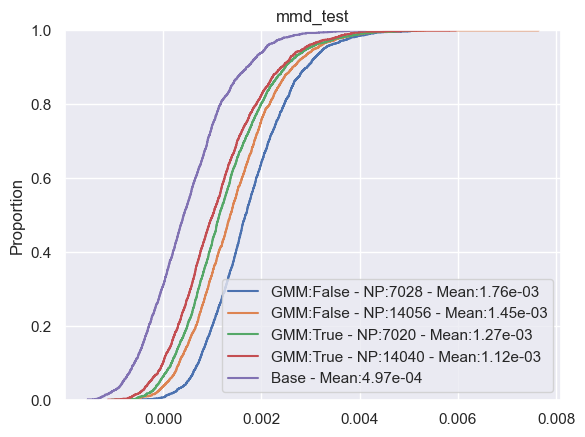

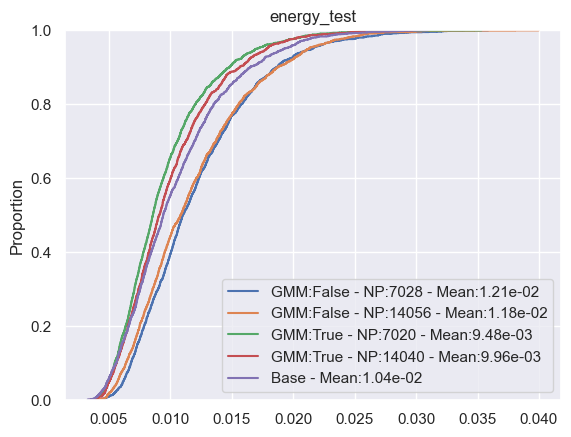

In [22]:
for col in exp_df['scores'].columns:
    for i in range(len(exp_df)):
        sns.ecdfplot(data=np.array(exp_df['scores'][col].iloc[i]), 
                    label=f"GMM:{exp_df['training']['gmm'].iloc[i]} - NP:{exp_df['training']['num_params'].iloc[i]} - Mean:{np.mean(exp_df['scores'][col].iloc[i]):0.2e}")
    sns.ecdfplot(data=np.array(base_df['scores'][col][0]), label=f"Base - Mean:{np.mean(base_df['scores'][col].iloc[0]):0.2e}")
    plt.title(col)
    plt.legend()
    plt.show()

In [23]:
## save exp_df and base_df
exp_df.to_pickle('outputs/exp_df_denmark.pkl')
base_df.to_pickle('outputs/base_df_denmark.pkl')